# Objective

The objective of this exercise is to identify a fraudlent transaction as accurately as possible.

Import neccessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

Load the dataset

In [3]:
data = pd.read_csv("Fraud.csv")

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.shape[0]
data.shape[1]

11

In [6]:
data.isnull().sum().any()

False

In [7]:
print("No of Valid transactions:",data.isFraud.value_counts()[0],'which is ',round(data.isFraud.value_counts()[0]/data.shape[0] * 100,2),'%')
print("No of Fraud transactions:",data.isFraud.value_counts()[1],'which is ',round(data.isFraud.value_counts()[1]/data.shape[0] * 100,2),'%')

data.isFraud.value_counts()

No of Valid transactions: 6354407 which is  99.87 %
No of Fraud transactions: 8213 which is  0.13 %


0    6354407
1       8213
Name: isFraud, dtype: int64

In [8]:
print("No of transactions Flagged as Valid:",data.isFlaggedFraud.value_counts()[0])
print("No of transactions Flagged as Fraud:",data.isFlaggedFraud.value_counts()[1])

No of transactions Flagged as Valid: 6362604
No of transactions Flagged as Fraud: 16


In [9]:
print("Any transaction with amount less than or equal to 0?")
print(len(data[data.amount<=0]))
print("What type of transactions are they?")
print(data[data.amount<=0]['type'].value_counts().index[0])
print("Are all these marked as Fraud Transactions?")
data[data.amount<=0]['isFraud'].value_counts()[1] == len(data[data.amount<=0])

Any transaction with amount less than or equal to 0?
16
What type of transactions are they?
CASH_OUT
Are all these marked as Fraud Transactions?


True

In [10]:
data_temp = data[data.isFlaggedFraud==1]
print("How many frauds transactions are Flagged?:")
print("\t",len(data_temp))

print("What type of transactions are they?")
print("\t",data_temp['type'].value_counts().index[0])

print("Are all these flagged also marked as Fraud Transactions?")
print("\t",data_temp['isFraud'].value_counts()[1] == len(data_temp))

print("Minumum amount transfered in these transactions")
print("\t",data_temp.amount.min())

print("Maximum amount transfered in these transactions")
print("\t",data_temp.amount.max())

How many frauds transactions are Flagged?:
	 16
What type of transactions are they?
	 TRANSFER
Are all these flagged also marked as Fraud Transactions?
	 True
Minumum amount transfered in these transactions
	 353874.22
Maximum amount transfered in these transactions
	 10000000.0


All the fraud trnasactions belong to Transfer or Cash-out type, so discard data corresponding to other types

In [11]:
data = data.loc[(data['type'].isin(['TRANSFER', 'CASH_OUT']))]
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


# Data Visualization

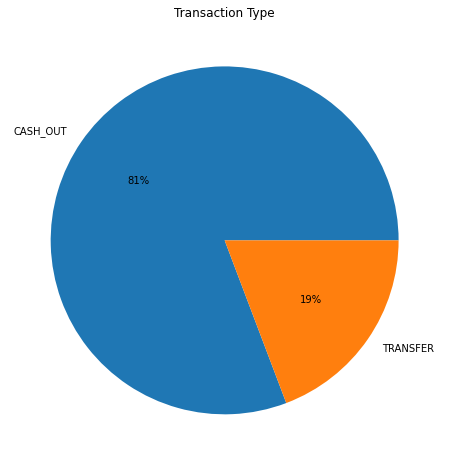

In [12]:
plt.figure(figsize=(10,8))
plt.pie(data.type.value_counts().values,labels=data.type.value_counts().index,  autopct='%.0f%%')
plt.title("Transaction Type")
plt.show()

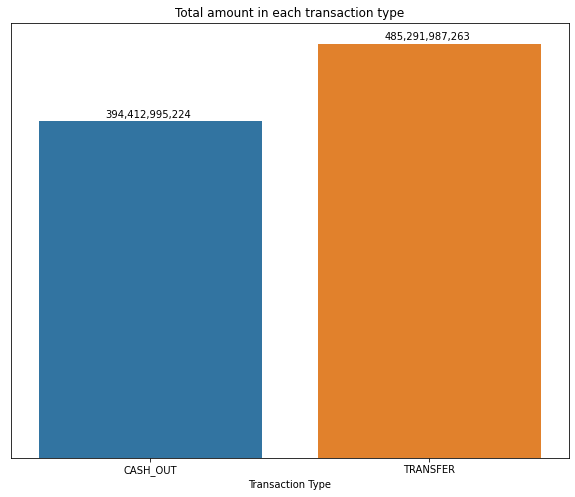

In [13]:
d = data.groupby('type')['amount'].sum()
plt.figure(figsize=(10,8))
ax = sns.barplot(x=d.index,y=d.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))
    
plt.title("Total amount in each transaction type")
plt.yticks([])
plt.xlabel("Transaction Type")
plt.show()

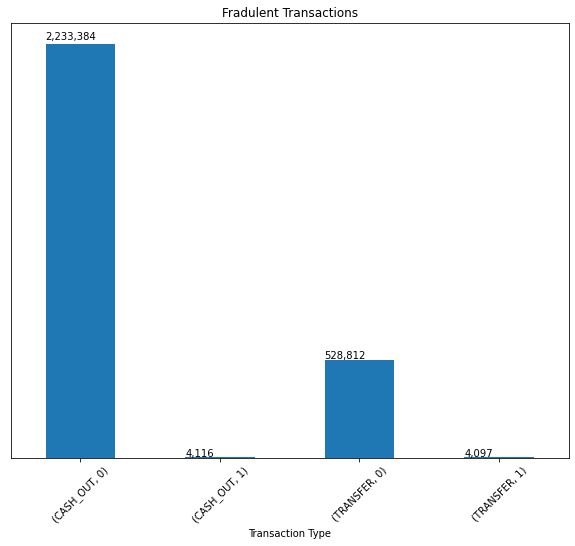

In [14]:
plt.figure(figsize=(10,8))
ax = data.groupby(['type','isFraud']).size().plot(kind='bar')

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
plt.title("Fradulent Transactions")
plt.xlabel("Transaction Type")
plt.yticks([])
plt.xticks(rotation=45)
plt.show()

Delete unwanted features (Remove isFlaggedFraud and keep isFraud as target feature)

In [15]:
data.drop(['step','type','nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,181.00,181.0,0.0,0.0,0.00,1
3,181.00,181.0,0.0,21182.0,0.00,1
15,229133.94,15325.0,0.0,5083.0,51513.44,0
19,215310.30,705.0,0.0,22425.0,0.00,0
24,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [16]:
ss = StandardScaler()

data.amount         = ss.fit_transform(data[['amount']])
data.oldbalanceOrg  = ss.fit_transform(data[['oldbalanceOrg']])
data.oldbalanceDest = ss.fit_transform(data[['oldbalanceDest']])
data.newbalanceOrig = ss.fit_transform(data[['newbalanceOrig']])
data.newbalanceDest = ss.fit_transform(data[['newbalanceDest']])

In [17]:
X = data.drop(["isFraud"],axis=1)
y = data.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2077806, 5), (692603, 5), (2077806,), (692603,))

In [18]:
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   #Ploting the confusion matrix 
plt.figure(figsize=(6,6))
plt.title("Confusion Matrix")
sns.set(font_scale=1.5) 
sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

f1 score: 0.5945232596502804
Accuracy of this model: 0.9982255346858157


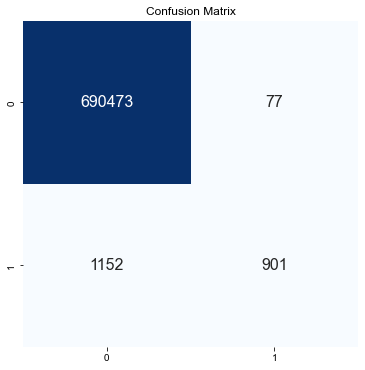

In [20]:
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

f1score = f1_score(y_test, lr_pred)
print('f1 score:', f1score)

conf_matrix(y_test, lr_pred)
 
acc_lr= accuracy_score(y_test, lr_pred)
print("Accuracy of this model:", acc_lr)

Since the dataset extremely imbalanced, some workaround can be done to overcome this. Below are all the methods listed

# 1. Up-sample Minority Class

Randomly duplicate the data from the minority class.

In [21]:
n = data.isFraud.value_counts()[0]
df_majority = data[data.isFraud==0]
df_minority = data[data.isFraud==1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=n, random_state=123)
# 1.Sample with replacementRandomly duplicate the data from the minority class.
# 2.to match majority class
# 3.reproducible results

# Combine majority class with unsample minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
print("The new class count are:")
df_upsampled.isFraud.value_counts()

The new class count are:


0    2762196
1    2762196
Name: isFraud, dtype: int64

f1 score for the testing data:	 0.8973326058848589
Accuracy of thie model:		 0.9005356607568761


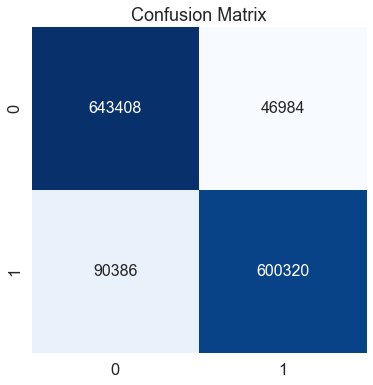

In [22]:
X = df_upsampled.drop(["isFraud"],axis = 1)
y = df_upsampled.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)

lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)

# Predicting on the test data
up_scale_pred = lr.predict(X_test)
 
f1up_scale_pred = f1_score(y_test, up_scale_pred)
print('f1 score for the testing data:\t', f1up_scale_pred)
 
conf_matrix(y_test,up_scale_pred)

acc_up_scale=accuracy_score(y_test, up_scale_pred)
print("Accuracy of thie model:\t\t",acc_up_scale)

# 2. Down-sample Majority Class

Randomly remove data from the majority class

In [23]:
n = data.isFraud.value_counts()[1]

# Separate majority and minority classes
df_majority = data[data.isFraud==0]
df_minority = data[data.isFraud==1]

 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=n,      # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
print("The new class count are:")
print(df_downsampled.isFraud.value_counts())

The new class count are:
0    8213
1    8213
Name: isFraud, dtype: int64


How many class does the model predict? [0 1]
Count in each class:			 0 : 8918
					 1 : 7508
f1 score for the testing data:		 0.8760256981108073
Accuracy of the model:			 0.881346645561914


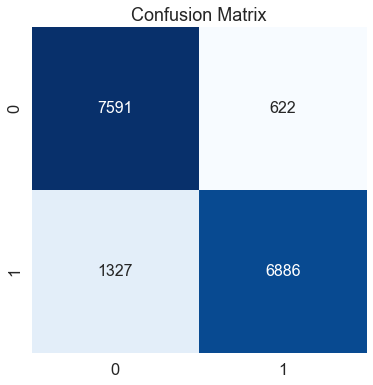

In [24]:
y = df_downsampled.isFraud
X = df_downsampled.drop(['isFraud'], axis=1)
 
lr = LogisticRegression().fit(X, y)
 
down_scale_pred = lr.predict(X)
 
print("How many class does the model predict?",np.unique( down_scale_pred ))
print("Count in each class:\t\t\t","0 :",len(down_scale_pred[down_scale_pred==0]))
print("\t\t\t\t\t 1 :",len(down_scale_pred[down_scale_pred==1]))

#Calculating and printing the f1 score 
f1down_scale_pred = f1_score(y, down_scale_pred)
print('f1 score for the testing data:\t\t', f1down_scale_pred)

conf_matrix(y, down_scale_pred)
      
acc_down_scale=accuracy_score(y, down_scale_pred) 
print("Accuracy of the model:\t\t\t", acc_down_scale)

# 3. Tree-Based Algorithms

In [25]:
y = data.isFraud
X = data.drop(['isFraud'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Train model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
# Predict on training set
rfc_pred = rfc.predict(X_test)

AUROC:			 0.9938323463758693
f1 score:		 0.8497715667831228
Accuracy of the model:	 0.9991928998286176


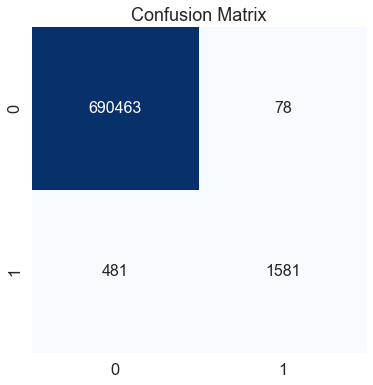

In [26]:
prob_y = rfc.predict_proba(X_test)
prob_y = [p[1] for p in prob_y]

print("AUROC:\t\t\t",roc_auc_score(y_test, prob_y))

f1_rfc = f1_score(y_test, rfc_pred)
print('f1 score:\t\t', f1_rfc)

conf_matrix(y_test, rfc_pred)

acc_rfc=accuracy_score(y_test, rfc_pred) 
print("Accuracy of the model:\t", acc_rfc)

In [27]:
data = {'Model':['Logistic Regression','UpScale Logistic Regression','DownScale Logistic Regression','RandomForest'],
        'f1 score':[f1score,f1up_scale_pred,f1down_scale_pred,f1_rfc],
        'Accuracy Score':[acc_lr,acc_up_scale,acc_down_scale,acc_rfc]}

comparision_table=pd.DataFrame(data)                               
print(comparision_table)

                           Model  f1 score  Accuracy Score
0            Logistic Regression  0.594523        0.998226
1    UpScale Logistic Regression  0.897333        0.900536
2  DownScale Logistic Regression  0.876026        0.881347
3                   RandomForest  0.849772        0.999193
